## RLE (relative geolocation error) estimation at randomly selected points

This notebook is for calculating <B>RLE (relative geolocation error)</B> of Sentinel-1 coregistered SLCs at randomly selected points using ISCE2's Ampcor.

<b><I>Inputs</I></b>: &emsp;   Sentinel-1 coregistered SLCs produced by ISCE2     <br>
<b><I>Relative Orbit</I></b>: &emsp; 71 (descending track)    <br>
<b><I>Period</I></b>: &emsp; 2021/01/06 - 2021/12/20 (57 SLCs)<br>
<b><I>Subswath</I></b>: &emsp; IW2 (2 bursts) <br>
<b><I>Location</I></b>: &emsp; Rosamond, CA

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import os, glob
import pickle
import math
from IPython.display import clear_output

import itertools

import matplotlib.pyplot as plt
from matplotlib import patches
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 24})

from osgeo import gdal

import warnings
warnings.filterwarnings('ignore')

import isce
import isceobj
from isceobj.Util.mathModule import is_power2
from isceobj.Orbit.Orbit import Orbit, StateVector
from isce.components.mroipac.ampcor.Ampcor import Ampcor

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


### Preparing input parameters

In [2]:
def loadProduct(xmlname):
        '''
        Load the product using Product Manager.
        '''

        from iscesys.Component.ProductManager import ProductManager as PM

        pm = PM()
        pm.configure()

        obj = pm.loadProduct(xmlname)

        return obj

In [3]:
xmlfile = 'reference/IW2.xml'  #ISCE2 xml file
info = loadProduct(xmlfile)  #loading xml file

nbursts = info.numberOfBursts  #number of bursts in CSLC file

In [4]:
#defining parameters related with S1 annotation xml file
xmlfile_S1 = './SLC/S1A_IW_SLC__1SDV_20210106T135212_20210106T135240_036018_043864_B5AF.SAFE/annotation/s1a-iw2-slc-vv-20210106t135212-20210106t135240-036018-043864-005.xml'  #S1 annotation xml file
import xml.etree.ElementTree as ET

xmltree = ET.parse(xmlfile_S1)
xmlroot = xmltree.getroot()      #reading S1 annotation xml file

In [5]:
#reading orbit info from xml
orb = Orbit()  #Orbit class

for sv in info.orbit.stateVectors.list:
    
    SV = StateVector()
    
    SV.setTime(sv.getTime())
    SV.setPosition(sv.getPosition())
    SV.setVelocity(sv.getVelocity())
    
    orb.addStateVector(SV)

In [6]:
sensingStart = info.sensingStart
sensingMid = info.sensingMid
sensingStop = info.sensingStop

print(sensingStart,sensingMid,sensingStop)

#min, max time of data
orb.minTime = sensingStart
orb.maxTime = sensingStop

azimuthTimeInterval = info.bursts.burst1.azimuthTimeInterval   #line time interval

nearRange = info.startingRange
midRange = info.midRange
farRange = info.farRange
print('range (m) (near, mid, far)',nearRange, midRange, farRange)

#approximate terrain height 
terrainHeight = info.bursts.burst1.terrainHeight

rangePixelSize = info.bursts.burst1.rangePixelSize
print('rangepixelsize (m): ',rangePixelSize)

azimuthPixelSize = float(xmlroot.find('.//azimuthPixelSpacing').text)   #reading from S1 annotation xml 
print('azimuthPixelSize (m): ',azimuthPixelSize)

2021-01-06 13:52:29.060062 2021-01-06 13:52:31.990258 2021-01-06 13:52:34.920453
range (m) (near, mid, far) 846067.2431679851 875603.7612204608 905140.2792729363
rangepixelsize (m):  2.329562114715323
azimuthPixelSize (m):  13.94096


### Calculating pixel location of random points

In [7]:
#pixel location of random points 
xloc = []      
yloc = []      

#interest area
min_lat = 34.797
max_lat = 34.806
min_lon = -118.097
max_lon = -118.032

lat_ = [min_lat, max_lat]
lon_ = [min_lon, max_lon]

comb_ = list(itertools.product(lat_, lon_))


for lat, lon in comb_:
    
    llh = [lat, lon, terrainHeight]
    
    tguess, rng = orb.geo2rdr(llh)    #main calculation for conversion between llh and pixel location
    
    xloc.append(int(np.floor((rng-nearRange)/rangePixelSize)))
    yloc.append(int(np.floor((tguess - sensingStart).total_seconds()/azimuthTimeInterval)))

### Selecting random locations and calculating their pixel location in image

In [8]:
min_x = min(xloc); max_x = max(xloc); min_y = min(yloc); max_y = max(yloc)

n_pixels = 20   #number of random pixels
randX = np.random.randint((min_x),(max_x), n_pixels)  
randY = np.random.randint((min_y),(max_y), n_pixels)

df = pd.DataFrame(data={'ID':np.arange(n_pixels),'xloc':randX,'yloc':randY})

In [9]:
#start and stop time of bursts
bursts_start_time = []
bursts_stop_time = []

for ii in range(nbursts):
    burst_ind = ii + 1
    burstname = 'info.bursts.burst' + str(burst_ind)

    _ = eval(burstname+'.sensingStart')
    if (ii != 0):
        _ += dt.timedelta(seconds=azimuthTimeInterval * eval(burstname+'.firstValidLine'))
    
    bursts_start_time.append(_)

#determining where the random points locate among multiple bursts
loc_bursts = []   #location of random points in multiple bursts

for idx, row in df.iterrows():

    _aztime =sensingStart + dt.timedelta(seconds=azimuthTimeInterval * row['yloc'])     #azimuth time at random point

    cnt = 0
    for ii in range(nbursts):
        if (_aztime >= bursts_start_time[ii]):
            cnt += 1

    loc_bursts.append(cnt)

print('Burst location of random points: ',loc_bursts)
df['burst_NO'] = loc_bursts

#reading all the bursts
burst_list = []
for ii in range(nbursts):
    _ = 'burst_'+str(f"{ii+1:02}")   
    burst_list.append(_)

burst_lists = {key:[] for key in burst_list}  #defining empty list for burst list (dictionary)

Burst location of random points:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


### Saving deramped burst SLCs before offset estimation

In [10]:
def computeRamp(burst):
    '''
    Returns the ramp function as a numpy array. 
    Modified from ISCE2's TOPSSwathSLCProduct.py
    '''
    Vs = np.linalg.norm(burst.orbit.interpolateOrbit(burst.sensingMid, method='hermite').getVelocity())
    Ks =   2 * Vs * burst.azimuthSteeringRate / burst.radarWavelength 
    rng = np.arange(burst.numberOfSamples) * burst.rangePixelSize + burst.startingRange
    eta =( np.arange(0, burst.numberOfLines) - (burst.numberOfLines//2)) * burst.azimuthTimeInterval
    f_etac = burst.doppler(rng)
    Ka     = burst.azimuthFMRate(rng)
    eta_ref = (burst.doppler(burst.startingRange) / burst.azimuthFMRate(burst.startingRange) ) - (f_etac / Ka)
    Kt = Ks / (1.0 - Ks/Ka)
    carr = np.pi * Kt[None,:] * ((eta[:,None] - eta_ref[None,:])**2)
    ramp = np.exp(-1j*carr)

    return ramp

In [11]:
#defining dates of produced SLCs
days=glob.glob('./merged/SLC/*')
days = [path.split('/')[-1] for path in days]
days = sorted(days)

In [12]:
if not os.path.isdir('./deramped_SLCs'):
    os.mkdir('./deramped_SLCs')
    
for day in days:
    
    outpklname = './deramped_SLCs/'+str(day)+'.pkl'
    
    if not os.path.exists(outpklname):
        
        SLCvrt = 'merged/SLC/'+str(day)+'/'+str(day)+'.slc.full.vrt'
        
        ds = gdal.Open(SLCvrt, gdal.GA_ReadOnly)
        slc = ds.GetRasterBand(1).ReadAsArray()
        ds = None
        
        for ii in range(nbursts):
        
            burst_ = ii+1    #selected burst
            burstname = 'burst_'+str(f"{burst_:02}")

            dir_SLCvrt = os.path.dirname(SLCvrt)
            tmp_vrt = dir_SLCvrt + '/_tmp_.vrt' #temporary vrtfile

            vrtTree = ET.parse(SLCvrt)      #parsing SLC vrt file
            vrtRoot = vrtTree.getroot()

            cnt = 0
            for sup in vrtRoot.findall('VRTRasterBand'):
                subs = sup.findall('SimpleSource')

                for sub in subs:
                    cnt += 1
                    if (cnt != burst_):
                        sup.remove(sub)

            vrtTree.write(tmp_vrt)
            vrtTree = None;  vrtRoot = None

            ds = gdal.Open(tmp_vrt, gdal.GA_ReadOnly)
            _ = ds.GetRasterBand(1).ReadAsArray()
            ds = None

            #deramping burst SLC
            ramp = computeRamp(info.bursts[ii])
            burst_start = int(np.round((info.bursts[ii].sensingStart - info.sensingStart)
                                       .total_seconds()/azimuthTimeInterval))    #first line of a burst
            burst_end = int(np.round((info.bursts[ii].sensingStop - info.sensingStart)
                                     .total_seconds()/azimuthTimeInterval))      #last line of a burst
            _[burst_start:burst_end+1,:] = _[burst_start:burst_end+1,:]*ramp    #deramping
            _[np.isnan(_)] = 0.0
            burst_lists[burstname] = _  #adding burst SLC to dictionary (keys in list)

            os.remove(tmp_vrt)
        
        with open(outpklname, 'wb') as f:
            pickle.dump(burst_lists,f)   
           

### Offset calculation using ampcor

In [13]:
class AmpcorPrep:
    #estimating offsets from two chips using ampcor
    
    def __init__(self, df, days, derampPath, n_neighbor, winWidth, winHeight, 
                 searchWidth, searchHeight, ovs, xstep, ystep):

        self.df = df   #pandas table
        self.days = days
        self.derampPath = derampPath 

        self.n_neighbor = n_neighbor
        self.winWidth = winWidth
        self.winHeight = winHeight
        self.xhalfwin = int(winWidth/2) + searchWidth
        self.yhalfwin = int(winHeight/2) + searchHeight

        self.searchWidth = searchWidth
        self.searchHeight = searchHeight
        self.ovs = ovs   #oversampling factor
        self.xstep = xstep
        self.ystep = ystep

        self.__check_inputs__()
        
    def __check_inputs__(self): 
        if not is_power2(self.winWidth):
            raise ValueError('Window size needs to be power of 2.') 

        if not is_power2(self.winHeight):
            raise ValueError('Window size needs to be power of 2.')
         
        if not is_power2(self.ovs):
            raise ValueError('Oversampling factor needs to be power of 2.')

        if (self.searchWidth%2 == 1):
            raise ValueError('Search window size width needs to be multiple of 2.')

        if (self.searchHeight%2 == 1):
            raise ValueError('Search window size width needs to be multiple of 2.')

    def run(self):
        ''' 
          finding correlation peak with ampcor
        '''
       
        def __create_cpxFile__(filename,dat,width,length):
            _img = isceobj.Image.createImage()
            _img.setFilename(filename)
            _img.setWidth(width)
            _img.setLength(length)
            _img.setAccessMode('write')
            _img.bands = 1
            DataType = 'CFLOAT'
            outtype = '<f'  #little endian (float)
            _img.dataType = DataType
            _img.scheme = 'BIP'
            _img.renderHdr()
            _img.renderVRT()
            _img.finalizeImage()

            fout = open(filename, "wb")
            dat_cpx = np.zeros((length,2*width))
            dat_cpx[:,::2] = np.real(dat)
            dat_cpx[:,1::2] = np.imag(dat)
            dat_cpx.astype(outtype).tofile(fout)   #little endian
            _img = None; dat_cpx = None
 
        if not os.path.isdir('./cross_correlation_random_points'):
            os.mkdir('./cross_correlation_random_points')

        for i,ref_day in enumerate(self.days):
            sec_days = self.days[i+1:min(len(self.days),i+1+self.n_neighbor)]

            for sec_day in sec_days:
                print(f'Ref_image: {ref_day}; Sec_image: {sec_day}')
                if os.path.isfile(f'./cross_correlation_random_points/{ref_day}_{sec_day}.csv'):
                    print(f'./cross_correlation_random_points/{ref_day}_{sec_day}.csv exist!')
                    continue

                #reading deramped burst SLC data
                refpkl = self.derampPath+'/'+str(ref_day)+'.pkl'             
                secpkl = self.derampPath+'/'+str(sec_day)+'.pkl'             

                with open(refpkl,'rb') as f:
                    ref_burst_lists = pickle.load(f)
                with open(secpkl,'rb') as f:
                    sec_burst_lists = pickle.load(f)

                dx = []
                dy = []
                snr = [] 
                for xoff, yoff,burst_no in zip(self.df['xloc'],self.df['yloc'],self.df['burst_NO']):
                    ref_slc_deramp = ref_burst_lists['burst_'+str(f"{burst_no:02}")]
                    sec_slc_deramp = sec_burst_lists['burst_'+str(f"{burst_no:02}")] 

                    slccrop_ref = ref_slc_deramp[(yoff-self.yhalfwin+1):(yoff+self.yhalfwin),
                                                 (xoff-self.xhalfwin+1):(xoff+self.xhalfwin)]
                    slccrop_sec = sec_slc_deramp[(yoff-self.yhalfwin+1):(yoff+self.yhalfwin),
                                                 (xoff-self.xhalfwin+1):(xoff+self.xhalfwin)] 
                    (chiplength, chipwidth) = slccrop_ref.shape

                    objAmpcor = Ampcor()
                    objAmpcor.configure()
                    objAmpcor.setImageDataType1('complex')
                    objAmpcor.setImageDataType2('complex')
                    objAmpcor.acrossGrossOffset = 0
                    objAmpcor.downGrossOffset = 0

                    objAmpcor.windowSizeWidth = self.winWidth
                    objAmpcor.windowSizeHeight = self.winHeight
                    objAmpcor.searchWindowSizeWidth = self.searchWidth
                    objAmpcor.searchWindowSizeHeight = self.searchHeight
                    objAmpcor.oversamplingFactor = self.ovs   
                    
                    objAmpcor.setFirstPRF(1.0) 
                    objAmpcor.setSecondPRF(1.0)
                    objAmpcor.setFirstRangeSpacing(1.0)
                    objAmpcor.setSecondRangeSpacing(1.0)

                    #saving reference and secondary chips
                    refFile = 'ref.dat'; refXML = refFile + '.xml'; refVRT = refFile + '.vrt'
                    __create_cpxFile__(refFile,slccrop_ref,chipwidth,chiplength)

                    secFile = 'sec.dat'; secXML = secFile + '.xml'; secVRT = secFile + '.vrt'
                    __create_cpxFile__(secFile,slccrop_sec,chipwidth,chiplength)

                    #loading saved chips 
                    referenceImg = isceobj.createImage()   #Empty image
                    referenceImg.load(refXML) #Load from XML file
                    referenceImg.setAccessMode('read')     #Set it up for reading 
                    referenceImg.createImage()             #Create File

                    secondaryImg = isceobj.createImage()    #Empty image
                    secondaryImg.load(secXML)   #Load it from XML file
                    secondaryImg.setAccessMode('read')      #Set it up for reading
                    secondaryImg.createImage()              #Create File

                    #ampcor: amplitude cross-correlation
                    objAmpcor.ampcor(referenceImg,secondaryImg)
                    clear_output(wait=False)   #clearing cell outputs

                    referenceImg.finalizeImage()
                    secondaryImg.finalizeImage()
                    referenceImg = None
                    secondaryImg = None

                    os.remove(refFile); os.remove(refXML); os.remove(refVRT)
                    os.remove(secFile); os.remove(secXML); os.remove(secVRT)

                    offField = objAmpcor.getOffsetField()  #output of ampcor 
                    field = np.array(offField.unpackOffsets())

                    if (field.size == 0): # if ampcor fail, set the snr to 0
                        dx.append(0.0);dy.append(0.0);snr.append(0.0)
                    else:
                                   
                        success = 0
                        for item in field:
                            if (item[0]==self.xhalfwin+1) and (item[2]==self.yhalfwin+1):
                                # when the field contains the offset of the patch we needs.
                                dx.append(item[1]),dy.append(item[3]),snr.append(item[4])
                                success = 1; break
                        if success!=1:
                            # the field do not contains the offset of the patch we needs. We average the offset field.
                            dx.append(field[:,1].mean());dy.append(field[:,3].mean());
                            snr.append(field[:,4].mean())

                offset_df = pd.DataFrame({'ID':list(self.df['ID']),'dx':dx,'dy':dy,'SNR':snr})
                offset_df['dx'] = offset_df['dx']*self.xstep
                offset_df['dy'] = offset_df['dy']*self.ystep

                offset_df.to_csv(f'./cross_correlation_random_points/{ref_day}_{sec_day}.csv',index=False)

In [14]:
#Running ampcor to find offsets
objOffset = AmpcorPrep(df,days,derampPath='./deramped_SLCs',n_neighbor=3,winWidth=128,
                                winHeight=128,searchWidth=4,searchHeight=4,ovs=64, 
                                xstep=rangePixelSize,ystep=azimuthPixelSize)
'''
     n_neighbor: number of neighbor pairs for calculating offsets
     winWidth, winHeight: window size for offset estimation
     searchWidth, searchHeight: search window size for offset estimation
     ovs: oversampling factor for correlation
     xstep, ystep: pixel spacing (m) in x/y
'''
objOffset.run()     #running ampcor

clear_output(wait=False)   #clearing cell outputs

In [15]:
#reading offsets from csv files
az_off = dict(); rng_off = dict(); snr = dict()

for ID in df['ID']:
    _az_off = np.empty((len(days),len(days)))
    _az_off[:] = np.nan
    _rng_off = _az_off.copy()
    _rng_off[:] = np.nan
    
    _snr = np.zeros_like(_az_off)
    az_off[ID] = _az_off
    rng_off[ID] = _rng_off
    snr[ID] = _snr
    
for csv_file_path in glob.glob('./cross_correlation_random_points/*.csv'):
    csv_file_name = csv_file_path.split('/')[-1]
    ref_day = csv_file_name[0:8]   #reference date
    sec_day = csv_file_name[9:17]  #secondary date
    ref_i = days.index(ref_day)    #index of reference date 
    sec_i = days.index(sec_day)    #index of secondary date
    
    _df = pd.read_csv(csv_file_path)
    for ID,dx,dy,_snr in zip(_df['ID'],_df['dx'],_df['dy'],_df['SNR']):
        az_off[ID][ref_i,sec_i] = dy
        rng_off[ID][ref_i,sec_i] = dx
        snr[ID][ref_i,sec_i] = _snr

In [16]:
#all calculated range and azimuth offsets 
all_az_off = []; all_rng_off = []; all_snr = []

for ii in az_off.keys():
    all_az_off.append(np.concatenate(az_off[ii]))
    all_rng_off.append(np.concatenate(rng_off[ii]))
    all_snr.append(np.concatenate(snr[ii]))

all_az_off = np.concatenate(all_az_off)
all_rng_off = np.concatenate(all_rng_off)
all_snr = np.concatenate(all_snr)

snr_threshold = 1.   #snr threshold

df_RLE = pd.DataFrame({'rng_off':all_rng_off, 'az_off':all_az_off, 'snr':all_snr})
df_RLE = df_RLE[(df_RLE['rng_off']!=np.nan) & (df_RLE['az_off']!=np.nan) 
                & (df_RLE['snr']>snr_threshold)].reset_index(drop=True)

#### Displaying RLEs at random points

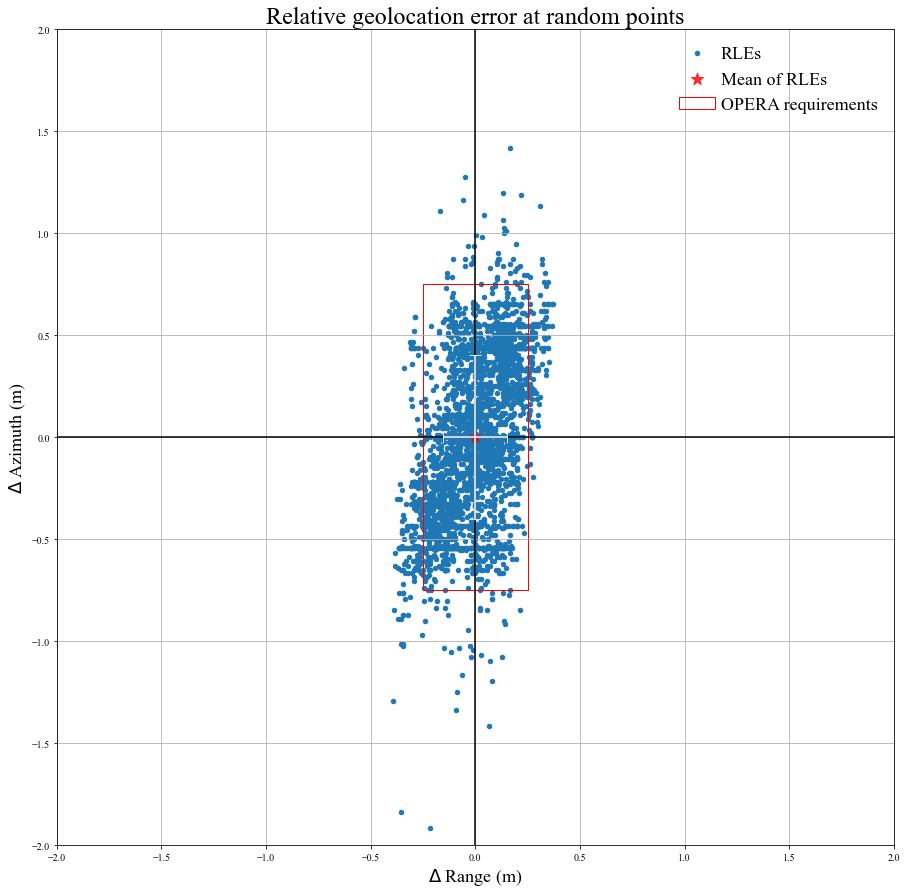

In [17]:
rng_rqmt = 0.5  #OPERA requirements for range offsets (0.25 m)
az_rqmt = 1.5   #OPERA requirements for azimuth offsets (0.75 m)  

fig,ax = plt.subplots(1,1,figsize=(15,15))
sc = ax.scatter(df_RLE['rng_off'],df_RLE['az_off'],s=20)
rect = patches.Rectangle((-rng_rqmt/2,-az_rqmt/2),rng_rqmt,az_rqmt,
                         linewidth=1,edgecolor='r',facecolor='none') 
ax.add_patch(rect)   #box displaying OPERA requirements
ax.grid(True)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_title('Relative geolocation error at random points', fontsize=24)
ax.set_xlabel('$\Delta$ Range (m)', fontsize=18)
ax.set_ylabel('$\Delta$ Azimuth (m)', fontsize=18)
rngMean = np.mean(df_RLE['rng_off'])
rngStd = np.std(df_RLE['rng_off'])
azMean = np.mean(df_RLE['az_off'])
azStd = np.std(df_RLE['az_off'])
ax.errorbar(rngMean,azMean,yerr=azStd,xerr=rngStd,color='w',lw=2,alpha=0.8,capsize=6)
sc_mean = ax.scatter(rngMean,azMean,alpha=0.8,c='r',s=160,marker='*')
ax.legend([sc,sc_mean,rect],['RLEs','Mean of RLEs','OPERA requirements'], fontsize=18,
          frameon=False,handletextpad=0.3)
fig.savefig('RLE.png',dpi=300,bbox_inches='tight')

In [18]:
print('mean RLE in range: ',np.mean(df_RLE['rng_off']), 'std ALE in range: ',np.std(df_RLE['rng_off']))
print('mean RLE in azimuth: ',np.mean(df_RLE['az_off']), 'std ALE in azimuth: ',np.std(df_RLE['az_off']))

mean RLE in range:  -0.0030652713621183167 std ALE in range:  0.15265940485389856
mean RLE in azimuth:  0.0008020012500000004 std ALE in azimuth:  0.40374616194718904
